# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.


#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE

from common_utils import MLP, CustomDataset, loss_fn
from common_utils import split_dataset, preprocess_dataset
from common_utils import EarlyStopper


Early_stopper = EarlyStopper(patience=3)
epochs = 100


def preprocess(df):
    # YOUR CODE HERE
    X_train, y_train, X_test, y_test = split_dataset(df=df,
                                                     columns_to_drop = ['filename', 'label'],
                                                     test_size=0.25,
                                                     random_state=26)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)

X_train, X_test = X_train_scaled, X_test_scaled

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    for batch_size in parameters:
        
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []

        
        for train_index, val_index in kf.split(X_train):
            
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
            
            # Ensures that X_train and X_val are scaled
            X_train_fold, X_val_fold = preprocess_dataset(X_train_fold, X_val_fold)

            # Convert each to tensor
            X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
            y_train_fold = torch.tensor(y_train_fold, dtype=torch.float32)
            X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
            y_val_fold = torch.tensor(y_val_fold, dtype=torch.float32)


            X_train_scaled_dict[batch_size].append(X_train_fold)
            X_val_scaled_dict[batch_size].append(X_val_fold)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [64, 128, 256, 512, 1024]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train, y_train)

3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [4]:
# YOUR CODE HERE

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_loss += loss.item()
        correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()


        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Update Weight
        optimizer.step()
    
        if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct
    

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5).type(torch.float) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct


def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, name='batch_size'):
    """
    returns:
    cross_validation_accuracies(list) where cross_validation_accuracies[i] is the cross validation accuracy for the ith parameter value
    cross_validation_times(list) where cross_validation_times[i] is the mean time taken on the last epoch for the ith parameter value
    """

    cross_validation_accuracies = []
    cross_validation_times = []
    
    

    for batch_size in batch_sizes:
        
        print(f"Training for Batch size = {batch_size}")
        model = MLP(no_features=X_train_scaled.shape[1], no_hidden=128, no_labels=1)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.BCELoss()
        Early_stopper = EarlyStopper(patience=3)
        accuracies, total_times, time_last_epoch = [], [], []
        
        # 5-fold cross validation
        for i in range(5):
            print(f"Fold {i+1}")
            
            train_data = CustomDataset(X_train_scaled_dict[batch_size][i], y_train_dict[batch_size][i])
            val_data = CustomDataset(X_val_scaled_dict[batch_size][i], y_val_dict[batch_size][i])

            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

            train_loss_, train_accuracy_ = [], [] 
            test_loss_, test_accuracy_ = [], []
            epoch_times = []
            t = 0
            
            for epoch in range(epochs):
                
                print(f"Epoch {epoch+1}\n-------------------------------")

                start = time.time()
                
                train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
                test_loss, test_accuracy = test_loop(val_dataloader, model, loss_fn)
                
                end = time.time()
                t += end - start
                epoch_times.append(end - start)
                
                train_loss_.append(train_loss), train_accuracy_.append(train_accuracy)
                test_loss_.append(test_loss), test_accuracy_.append(test_accuracy)
                
                
                # Early Stopper
                if Early_stopper.early_stop(test_loss): 
                    print("Done!")
                    break

            
            # Accuracy for the current Fold at last Epoch
            accuracies.append(test_accuracy_[-1])

            # Total Time taken
            total_times.append(t)#*1000 / (epochs) )
            
            # Time taken for the current Fold at last Epoch
            time_last_epoch.append(epoch_times[-1])
            
            print(f"Batch size: {batch_size}, Fold: {i}, Time taken: {total_times[-1]:>3f}s , Accuracy: {accuracies[-1]:>2f} , Time taken last epoch: {time_last_epoch[-1]:>3f}s ")        

        # Mean Accuracy for the Batch Size (Mean of Accuracy at Last Epoch for each Fold)
        cross_validation_accuracies.append(np.mean(accuracies))

        # Mean Time taken for the Batch Size (Mean of Time at Last Epoch for each Fold)
        cross_validation_times.append(np.mean(time_last_epoch))
        
        print(f"batch-size {batch_size} last epoch time {cross_validation_times[-1]:>3f} accuracy {cross_validation_accuracies[-1]:>2f}")

    return cross_validation_accuracies, cross_validation_times



batch_sizes = [64, 128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


Training for Batch size = 64
Fold 1
Epoch 1
-------------------------------
loss: 0.694946  [   64/ 7233]


C:\Users\Hendy\OneDrive\Desktop\SC4001\Assignments\common_utils.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float)
C:\Users\Hendy\OneDrive\Desktop\SC4001\Assignments\common_utils.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y =torch.tensor(y, dtype=torch.float).unsqueeze(1)


loss: 0.709281  [ 6464/ 7233]
Train Error: 
 Accuracy: 56.4%, Avg loss: 0.684336 

Test Error: 
 Accuracy: 57.3%, Avg loss: 0.681795 

Epoch 2
-------------------------------
loss: 0.670358  [   64/ 7233]
loss: 0.654641  [ 6464/ 7233]
Train Error: 
 Accuracy: 59.9%, Avg loss: 0.669487 

Test Error: 
 Accuracy: 62.1%, Avg loss: 0.657731 

Epoch 3
-------------------------------
loss: 0.635150  [   64/ 7233]
loss: 0.677643  [ 6464/ 7233]
Train Error: 
 Accuracy: 62.2%, Avg loss: 0.650096 

Test Error: 
 Accuracy: 63.5%, Avg loss: 0.651351 

Epoch 4
-------------------------------
loss: 0.642317  [   64/ 7233]
loss: 0.639890  [ 6464/ 7233]
Train Error: 
 Accuracy: 64.0%, Avg loss: 0.631877 

Test Error: 
 Accuracy: 64.1%, Avg loss: 0.640751 

Epoch 5
-------------------------------
loss: 0.640850  [   64/ 7233]
loss: 0.560175  [ 6464/ 7233]
Train Error: 
 Accuracy: 65.8%, Avg loss: 0.621603 

Test Error: 
 Accuracy: 65.8%, Avg loss: 0.629307 

Epoch 6
-------------------------------
loss:

Train Error: 
 Accuracy: 63.6%, Avg loss: 0.631144 

Test Error: 
 Accuracy: 65.0%, Avg loss: 0.630659 

Epoch 6
-------------------------------
loss: 0.625519  [  128/ 7233]
Train Error: 
 Accuracy: 66.6%, Avg loss: 0.613303 

Test Error: 
 Accuracy: 65.2%, Avg loss: 0.618923 

Epoch 7
-------------------------------
loss: 0.627754  [  128/ 7233]
Train Error: 
 Accuracy: 67.3%, Avg loss: 0.597897 

Test Error: 
 Accuracy: 65.9%, Avg loss: 0.611237 

Epoch 8
-------------------------------
loss: 0.562579  [  128/ 7233]
Train Error: 
 Accuracy: 67.8%, Avg loss: 0.588984 

Test Error: 
 Accuracy: 67.2%, Avg loss: 0.602961 

Epoch 9
-------------------------------
loss: 0.601501  [  128/ 7233]
Train Error: 
 Accuracy: 69.6%, Avg loss: 0.571207 

Test Error: 
 Accuracy: 69.2%, Avg loss: 0.588198 

Epoch 10
-------------------------------
loss: 0.571989  [  128/ 7233]
Train Error: 
 Accuracy: 70.5%, Avg loss: 0.560349 

Test Error: 
 Accuracy: 68.0%, Avg loss: 0.601270 

Epoch 11
----------

loss: 0.531495  [  256/ 7233]
Train Error: 
 Accuracy: 67.9%, Avg loss: 0.591082 

Test Error: 
 Accuracy: 67.0%, Avg loss: 0.634850 

Epoch 11
-------------------------------
loss: 0.562760  [  256/ 7233]
Train Error: 
 Accuracy: 70.5%, Avg loss: 0.569800 

Test Error: 
 Accuracy: 68.3%, Avg loss: 0.591800 

Epoch 12
-------------------------------
loss: 0.530349  [  256/ 7233]
Train Error: 
 Accuracy: 71.3%, Avg loss: 0.554897 

Test Error: 
 Accuracy: 67.8%, Avg loss: 0.606003 

Epoch 13
-------------------------------
loss: 0.561187  [  256/ 7233]
Train Error: 
 Accuracy: 71.5%, Avg loss: 0.549988 

Test Error: 
 Accuracy: 69.2%, Avg loss: 0.577952 

Epoch 14
-------------------------------
loss: 0.518544  [  256/ 7233]
Train Error: 
 Accuracy: 72.7%, Avg loss: 0.534510 

Test Error: 
 Accuracy: 69.4%, Avg loss: 0.602506 

Epoch 15
-------------------------------
loss: 0.489617  [  256/ 7233]
Train Error: 
 Accuracy: 73.6%, Avg loss: 0.524324 

Test Error: 
 Accuracy: 70.3%, Avg lo

Train Error: 
 Accuracy: 61.0%, Avg loss: 0.659427 

Test Error: 
 Accuracy: 61.4%, Avg loss: 0.660433 

Epoch 6
-------------------------------
loss: 0.679620  [  512/ 7233]
Train Error: 
 Accuracy: 62.4%, Avg loss: 0.644516 

Test Error: 
 Accuracy: 61.1%, Avg loss: 0.650193 

Epoch 7
-------------------------------
loss: 0.626748  [  512/ 7233]
Train Error: 
 Accuracy: 63.3%, Avg loss: 0.643034 

Test Error: 
 Accuracy: 61.4%, Avg loss: 0.651380 

Epoch 8
-------------------------------
loss: 0.647412  [  512/ 7233]
Train Error: 
 Accuracy: 63.0%, Avg loss: 0.642774 

Test Error: 
 Accuracy: 62.1%, Avg loss: 0.644488 

Epoch 9
-------------------------------
loss: 0.616849  [  512/ 7233]
Train Error: 
 Accuracy: 64.1%, Avg loss: 0.632451 

Test Error: 
 Accuracy: 63.3%, Avg loss: 0.638514 

Epoch 10
-------------------------------
loss: 0.616977  [  512/ 7233]
Train Error: 
 Accuracy: 65.2%, Avg loss: 0.621566 

Test Error: 
 Accuracy: 63.7%, Avg loss: 0.630878 

Epoch 11
----------

Train Error: 
 Accuracy: 81.6%, Avg loss: 0.409083 

Test Error: 
 Accuracy: 88.2%, Avg loss: 0.304372 

Done!
Batch size: 512, Fold: 4, Time taken: 0.525002s , Accuracy: 0.882190 , Time taken last epoch: 0.133001s 
batch-size 512 last epoch time 0.131200 accuracy 0.835335
Training for Batch size = 1024
Fold 1
Epoch 1
-------------------------------
loss: 0.692653  [ 1024/ 7233]
Train Error: 
 Accuracy: 52.7%, Avg loss: 0.691300 

Test Error: 
 Accuracy: 55.5%, Avg loss: 0.687527 

Epoch 2
-------------------------------
loss: 0.686189  [ 1024/ 7233]
Train Error: 
 Accuracy: 55.3%, Avg loss: 0.685297 

Test Error: 
 Accuracy: 55.8%, Avg loss: 0.683454 

Epoch 3
-------------------------------
loss: 0.679553  [ 1024/ 7233]
Train Error: 
 Accuracy: 57.3%, Avg loss: 0.678334 

Test Error: 
 Accuracy: 56.6%, Avg loss: 0.680055 

Epoch 4
-------------------------------
loss: 0.675338  [ 1024/ 7233]
Train Error: 
 Accuracy: 58.2%, Avg loss: 0.671594 

Test Error: 
 Accuracy: 56.7%, Avg loss:

Test Error: 
 Accuracy: 79.7%, Avg loss: 0.453899 

Done!
Batch size: 1024, Fold: 1, Time taken: 0.546002s , Accuracy: 0.796573 , Time taken last epoch: 0.106998s 
Fold 3
Epoch 1
-------------------------------
loss: 0.514474  [ 1024/ 7234]
Train Error: 
 Accuracy: 74.3%, Avg loss: 0.512166 

Test Error: 
 Accuracy: 81.4%, Avg loss: 0.440404 

Done!
Batch size: 1024, Fold: 2, Time taken: 0.117998s , Accuracy: 0.813606 , Time taken last epoch: 0.117998s 
Fold 4
Epoch 1
-------------------------------
loss: 0.506465  [ 1024/ 7234]
Train Error: 
 Accuracy: 75.0%, Avg loss: 0.494230 

Test Error: 
 Accuracy: 83.2%, Avg loss: 0.422865 

Epoch 2
-------------------------------
loss: 0.506238  [ 1024/ 7234]
Train Error: 
 Accuracy: 75.6%, Avg loss: 0.504412 

Test Error: 
 Accuracy: 83.4%, Avg loss: 0.417745 

Epoch 3
-------------------------------
loss: 0.499663  [ 1024/ 7234]
Train Error: 
 Accuracy: 75.0%, Avg loss: 0.495788 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.425837 

Epoch 4
--

4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

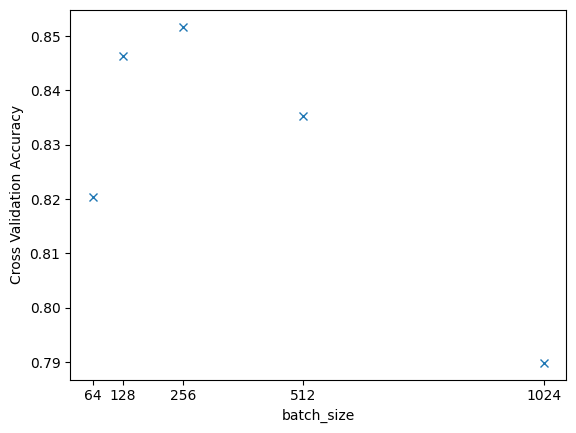

In [5]:
# YOUR CODE HERE

def plot_cross_validation_accuracies(cross_validation_accuracies, parameters, parameter_name):
    plt.plot(parameters, cross_validation_accuracies, marker='x',linestyle='None')
    plt.xlabel(parameter_name)
    plt.xticks(parameters, parameters)
    plt.ylabel('Cross Validation Accuracy')
    plt.show()

plot_cross_validation_accuracies(cross_validation_accuracies, batch_sizes, 'batch_size')

4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [6]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Time taken on Last Epoch Time': cross_validation_times  
#                    'Time Taken Total' : t_
                  })

df

,Batch Size,Time taken on Last Epoch Time
0,64,0.385199
1,128,0.270399
2,256,0.186006
3,512,0.131200
4,1024,0.110401


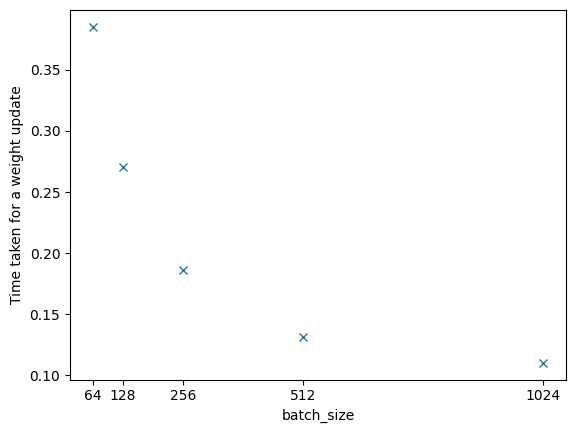

In [7]:
# plot last epoch time vs batch size

def plot_last_epoch_time_vs_batch_size(cross_validation_times, parameters, parameter_name):
    plt.plot(parameters, cross_validation_times, marker='x',linestyle='None')
    plt.xticks(parameters, parameters)
    plt.xlabel(parameter_name)
    plt.ylabel('Time taken for a weight update')
    plt.show()

plot_last_epoch_time_vs_batch_size(cross_validation_times, batch_sizes, 'batch_size')

,Batch Size,Last Epoch Time,Accuracy
0,64,0.385199,0.820404
1,128,0.270399,0.846284
2,256,0.186006,0.851707
3,512,0.131200,0.835335
4,1024,0.110401,0.789878


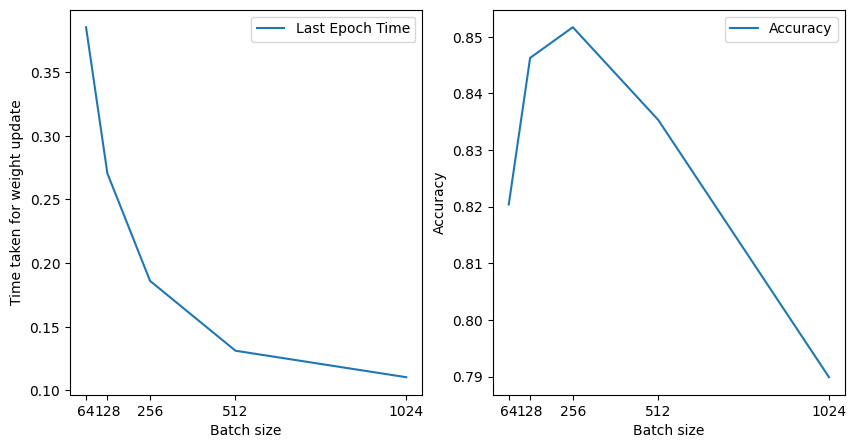

In [8]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': cross_validation_times,
                   'Accuracy': cross_validation_accuracies
                  })

display(df)

batch_size_axis = batch_sizes

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(batch_size_axis, cross_validation_times, label='Last Epoch Time')
plt.xlabel('Batch size')
plt.ylabel('Time taken for weight update')
plt.xticks(batch_sizes)  # Set x-axis ticks to match batch_sizes
plt.legend()

# Second subfigure plot training and test accuracy against epochs
plt.subplot(1, 2, 2)
plt.plot(batch_size_axis, cross_validation_accuracies, label='Accuracy')
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.xticks(batch_sizes)  # Set x-axis ticks to match batch_sizes
plt.legend()

plt.show()

In [9]:
# YOUR CODE HERE
optimal_batch_size = 512
reason = "Out of the 5 Batches given, we can see that time taken doesn’t improve much after **batch_size 512** (at the most optimal time) and we can see that accuracy is still quite high before it starting to descend further as shown in the graph, hence we can conclude that batch_size 512 is the Elbow point where it is not too costly and not too low accuracy (optimal point for both time and accuracy) which is why we choose batch size 512 as it represents the good balance between accuracy and time taken with the current machines CPU. "
analysis = "The accuracy improves steadily as the batch size increases from 64 to 256 (peak).\nHowever, the increase in accuracy slows down between batch sizes 256 and 512.\nThe training time decreases significantly up to batch size 512, but the decrease in training time between batch sizes 512 and 1024 is less significant.\n\nBased on these observations, the elbow point could be around batch size 512. Beyond this point, the increase in batch size may not result in significant improvements in accuracy while the decrease in training time is less pronounced. Therefore, batch size 512 appears to offer a good balance between accuracy and training time in this scenario."

print("optimal_batch_size : ",optimal_batch_size)
print("\nReason : ")
print("\n" +reason)
print("\nAnalysis based on graph : ")
print("\n" +analysis)


optimal_batch_size :  512

Reason : 

Out of the 5 Batches given, we can see that time taken doesn’t improve much after **batch_size 512** (at the most optimal time) and we can see that accuracy is still quite high before it starting to descend further as shown in the graph, hence we can conclude that batch_size 512 is the Elbow point where it is not too costly and not too low accuracy (optimal point for both time and accuracy) which is why we choose batch size 512 as it represents the good balance between accuracy and time taken with the current machines CPU. 

Analysis based on graph : 

The accuracy improves steadily as the batch size increases from 64 to 256 (peak).
However, the increase in accuracy slows down between batch sizes 256 and 512.
The training time decreases significantly up to batch size 512, but the decrease in training time between batch sizes 512 and 1024 is less significant.

Based on these observations, the elbow point could be around batch size 512. Beyond this p